### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Using cpu


/home/qubot/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [21]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
load_file_num = 1460
train_file_num = 1000
grid_size = 21
data = ReadCurrentAndField (foldername,filepattern, load_file_num)


data=data.reshape(load_file_num,grid_size,grid_size,grid_size,18)
mask = torch.cat((torch.ones(1,1,1,1,12),1e3*torch.ones(1,1,1,1,6)), dim=4)
# position unit mm, B field unit mT, Current unit Ampere
data = mask*data

sparsity = 4

Current_position =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:15].reshape(-1,15) # position unit mm
Bfield = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,15:].reshape(-1,3) # B field unit mT

print(data.shape)
print(data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:15].shape)
print('position shape', Current_position.shape)
print('Bfield shape', Bfield.shape)


torch.Size([1460, 21, 21, 21, 18])
torch.Size([1000, 6, 6, 6, 15])
position shape torch.Size([216000, 15])
Bfield shape torch.Size([216000, 3])


In [31]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop_v2 import train_ANN
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray, os
import torch.nn.functional as F

# construct dataset
dataset = eMNS_Dataset(
    x=Current_position,
    y=Bfield
)

# split the dataset to train, validation, test
train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# normailzation
extremes = dataset.train_norm_ANN(train_indices = train_set.indices, boundary_index=12)

###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

loss_func = lambda preds, y: F.l1_loss(preds, y)


################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 50,
                'lr_max': 1e-3,
                'lr_min': 2.5e-5,
                'batch_size': 128,
                'L2_norm'   : 0,
                'verbose': False,
                'schedule': [],
                'learning_rate_decay': 0.5,
                'num_input'   : num_input,
                'num_output'  : num_output,
                'fc_stages'   : fc_stages,
                'backward'    : False,
                'maxB'        : extremes[4],
                'minB'        : extremes[5],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'loss_func'   : loss_func
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    #resource_per_worker = {"CPU":1, "GPU":1}
)

run_config = RunConfig(name="EMS_ANN_v2", storage_path= "~/ray_results",checkpoint_config=CheckpointConfig(num_to_keep=1))

# def train_loop_per_worker(params):
#     train_GM(train_set=train_set, valid_set=valid_set,  device=device, config=params)

trainer = TorchTrainer(
    train_loop_per_worker = train_ANN,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,

)
result = trainer.fit()



(TorchTrainer pid=15281) Started distributed worker processes: 
(TorchTrainer pid=15281) - (ip=192.168.8.117, pid=15332) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=15332) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=15332) Epoch 0, Iteration 1519, loss = 0.0328
(RayTrainWorker pid=15332) Got rmse 2.63161563873291
(RayTrainWorker pid=15332) Got rmse 2.60054087638855
(RayTrainWorker pid=15332) 


(RayTrainWorker pid=15332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_v2/TorchTrainer_4cabe_00000_0_2024-04-17_11-33-47/checkpoint_000000)


(RayTrainWorker pid=15332) Epoch 1, Iteration 3038, loss = 0.0247
(RayTrainWorker pid=15332) Got rmse 2.2107324600219727


2024-04-17 11:34:05,704	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.150 s, which may be a performance bottleneck.
2024-04-17 11:34:05,705	WARNING util.py:202 -- The `process_trial_result` operation took 2.152 s, which may be a performance bottleneck.
2024-04-17 11:34:05,706	WARNING util.py:202 -- Processing trial results took 2.152 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:05,707	WARNING util.py:202 -- The `process_trial_result` operation took 2.154 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 2.190490961074829
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 2, Iteration 4557, loss = 0.0244
(RayTrainWorker pid=15332) Got rmse 1.9824398756027222


2024-04-17 11:34:08,876	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.228 s, which may be a performance bottleneck.
2024-04-17 11:34:08,878	WARNING util.py:202 -- The `process_trial_result` operation took 2.230 s, which may be a performance bottleneck.
2024-04-17 11:34:08,878	WARNING util.py:202 -- Processing trial results took 2.231 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:08,878	WARNING util.py:202 -- The `process_trial_result` operation took 2.231 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.9600518941879272
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 3, Iteration 6076, loss = 0.0206
(RayTrainWorker pid=15332) Got rmse 1.8751111030578613


2024-04-17 11:34:11,918	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.254 s, which may be a performance bottleneck.
2024-04-17 11:34:11,920	WARNING util.py:202 -- The `process_trial_result` operation took 2.257 s, which may be a performance bottleneck.
2024-04-17 11:34:11,921	WARNING util.py:202 -- Processing trial results took 2.257 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:11,921	WARNING util.py:202 -- The `process_trial_result` operation took 2.258 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.8549933433532715
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 4, Iteration 7595, loss = 0.0208
(RayTrainWorker pid=15332) Got rmse 1.7588845491409302


2024-04-17 11:34:15,257	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.522 s, which may be a performance bottleneck.
2024-04-17 11:34:15,258	WARNING util.py:202 -- The `process_trial_result` operation took 2.523 s, which may be a performance bottleneck.
2024-04-17 11:34:15,259	WARNING util.py:202 -- Processing trial results took 2.524 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:15,260	WARNING util.py:202 -- The `process_trial_result` operation took 2.525 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.74070143699646
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 5, Iteration 9114, loss = 0.0197


2024-04-17 11:34:19,337	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.936 s, which may be a performance bottleneck.
2024-04-17 11:34:19,340	WARNING util.py:202 -- The `process_trial_result` operation took 2.939 s, which may be a performance bottleneck.
2024-04-17 11:34:19,341	WARNING util.py:202 -- Processing trial results took 2.940 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:19,341	WARNING util.py:202 -- The `process_trial_result` operation took 2.940 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.641997218132019
(RayTrainWorker pid=15332) Got rmse 1.6234818696975708
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 6, Iteration 10633, loss = 0.0188
(RayTrainWorker pid=15332) Got rmse 1.5795526504516602


2024-04-17 11:34:24,005	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.743 s, which may be a performance bottleneck.
2024-04-17 11:34:24,007	WARNING util.py:202 -- The `process_trial_result` operation took 2.746 s, which may be a performance bottleneck.
2024-04-17 11:34:24,008	WARNING util.py:202 -- Processing trial results took 2.746 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:24,008	WARNING util.py:202 -- The `process_trial_result` operation took 2.747 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.5659908056259155
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 7, Iteration 12152, loss = 0.0180
(RayTrainWorker pid=15332) Got rmse 1.5685328245162964


2024-04-17 11:34:28,609	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.814 s, which may be a performance bottleneck.
2024-04-17 11:34:28,612	WARNING util.py:202 -- The `process_trial_result` operation took 2.818 s, which may be a performance bottleneck.
2024-04-17 11:34:28,613	WARNING util.py:202 -- Processing trial results took 2.818 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:28,613	WARNING util.py:202 -- The `process_trial_result` operation took 2.819 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.5541913509368896
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 8, Iteration 13671, loss = 0.0173
(RayTrainWorker pid=15332) Got rmse 1.4726506471633911


2024-04-17 11:34:32,764	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.114 s, which may be a performance bottleneck.
2024-04-17 11:34:32,765	WARNING util.py:202 -- The `process_trial_result` operation took 3.116 s, which may be a performance bottleneck.
2024-04-17 11:34:32,766	WARNING util.py:202 -- Processing trial results took 3.116 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:32,766	WARNING util.py:202 -- The `process_trial_result` operation took 3.117 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.4535202980041504
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 9, Iteration 15190, loss = 0.0158
(RayTrainWorker pid=15332) Got rmse 1.4468318223953247


2024-04-17 11:34:37,432	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.784 s, which may be a performance bottleneck.
2024-04-17 11:34:37,436	WARNING util.py:202 -- The `process_trial_result` operation took 2.787 s, which may be a performance bottleneck.
2024-04-17 11:34:37,436	WARNING util.py:202 -- Processing trial results took 2.788 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:37,437	WARNING util.py:202 -- The `process_trial_result` operation took 2.789 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.4309923648834229
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 10, Iteration 16709, loss = 0.0165
(RayTrainWorker pid=15332) Got rmse 1.398536205291748


2024-04-17 11:34:41,307	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.869 s, which may be a performance bottleneck.
2024-04-17 11:34:41,309	WARNING util.py:202 -- The `process_trial_result` operation took 2.871 s, which may be a performance bottleneck.
2024-04-17 11:34:41,311	WARNING util.py:202 -- Processing trial results took 2.873 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:41,312	WARNING util.py:202 -- The `process_trial_result` operation took 2.874 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.3799011707305908
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 11, Iteration 18228, loss = 0.0161
(RayTrainWorker pid=15332) Got rmse 1.3849904537200928


2024-04-17 11:34:45,054	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.721 s, which may be a performance bottleneck.
2024-04-17 11:34:45,057	WARNING util.py:202 -- The `process_trial_result` operation took 2.724 s, which may be a performance bottleneck.
2024-04-17 11:34:45,057	WARNING util.py:202 -- Processing trial results took 2.724 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:45,058	WARNING util.py:202 -- The `process_trial_result` operation took 2.725 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.3684196472167969
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 12, Iteration 19747, loss = 0.0164
(RayTrainWorker pid=15332) Got rmse 1.330987811088562


2024-04-17 11:34:49,572	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.762 s, which may be a performance bottleneck.
2024-04-17 11:34:49,574	WARNING util.py:202 -- The `process_trial_result` operation took 2.764 s, which may be a performance bottleneck.
2024-04-17 11:34:49,575	WARNING util.py:202 -- Processing trial results took 2.766 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:49,575	WARNING util.py:202 -- The `process_trial_result` operation took 2.766 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.3134077787399292
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 13, Iteration 21266, loss = 0.0153
(RayTrainWorker pid=15332) Got rmse 1.3349957466125488


2024-04-17 11:34:53,388	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.820 s, which may be a performance bottleneck.
2024-04-17 11:34:53,392	WARNING util.py:202 -- The `process_trial_result` operation took 2.824 s, which may be a performance bottleneck.
2024-04-17 11:34:53,392	WARNING util.py:202 -- Processing trial results took 2.824 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:53,393	WARNING util.py:202 -- The `process_trial_result` operation took 2.825 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.3200269937515259
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 14, Iteration 22785, loss = 0.0159
(RayTrainWorker pid=15332) Got rmse 1.272779107093811


2024-04-17 11:34:58,094	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.938 s, which may be a performance bottleneck.
2024-04-17 11:34:58,096	WARNING util.py:202 -- The `process_trial_result` operation took 2.940 s, which may be a performance bottleneck.
2024-04-17 11:34:58,097	WARNING util.py:202 -- Processing trial results took 2.941 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:34:58,098	WARNING util.py:202 -- The `process_trial_result` operation took 2.942 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.2543731927871704
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 15, Iteration 24304, loss = 0.0158
(RayTrainWorker pid=15332) Got rmse 1.2368675470352173


2024-04-17 11:35:01,957	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.783 s, which may be a performance bottleneck.
2024-04-17 11:35:01,962	WARNING util.py:202 -- The `process_trial_result` operation took 2.787 s, which may be a performance bottleneck.
2024-04-17 11:35:01,962	WARNING util.py:202 -- Processing trial results took 2.788 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:01,963	WARNING util.py:202 -- The `process_trial_result` operation took 2.788 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.218932032585144
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 16, Iteration 25823, loss = 0.0147
(RayTrainWorker pid=15332) Got rmse 1.2113920450210571


2024-04-17 11:35:05,867	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.866 s, which may be a performance bottleneck.
2024-04-17 11:35:05,869	WARNING util.py:202 -- The `process_trial_result` operation took 2.868 s, which may be a performance bottleneck.
2024-04-17 11:35:05,869	WARNING util.py:202 -- Processing trial results took 2.869 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:05,870	WARNING util.py:202 -- The `process_trial_result` operation took 2.869 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.192396879196167
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 17, Iteration 27342, loss = 0.0145
(RayTrainWorker pid=15332) Got rmse 1.1913535594940186


2024-04-17 11:35:10,697	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.878 s, which may be a performance bottleneck.
2024-04-17 11:35:10,701	WARNING util.py:202 -- The `process_trial_result` operation took 2.882 s, which may be a performance bottleneck.
2024-04-17 11:35:10,701	WARNING util.py:202 -- Processing trial results took 2.883 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:10,701	WARNING util.py:202 -- The `process_trial_result` operation took 2.883 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.1710481643676758
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 18, Iteration 28861, loss = 0.0139
(RayTrainWorker pid=15332) Got rmse 1.1717244386672974


2024-04-17 11:35:14,709	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.915 s, which may be a performance bottleneck.
2024-04-17 11:35:14,711	WARNING util.py:202 -- The `process_trial_result` operation took 2.917 s, which may be a performance bottleneck.
2024-04-17 11:35:14,712	WARNING util.py:202 -- Processing trial results took 2.918 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:14,713	WARNING util.py:202 -- The `process_trial_result` operation took 2.919 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.1537137031555176
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 19, Iteration 30380, loss = 0.0130
(RayTrainWorker pid=15332) Got rmse 1.1744405031204224


2024-04-17 11:35:18,621	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.843 s, which may be a performance bottleneck.
2024-04-17 11:35:18,624	WARNING util.py:202 -- The `process_trial_result` operation took 2.847 s, which may be a performance bottleneck.
2024-04-17 11:35:18,625	WARNING util.py:202 -- Processing trial results took 2.847 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:18,625	WARNING util.py:202 -- The `process_trial_result` operation took 2.848 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.1551413536071777
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 20, Iteration 31899, loss = 0.0139
(RayTrainWorker pid=15332) Got rmse 1.1730337142944336


2024-04-17 11:35:23,132	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.710 s, which may be a performance bottleneck.
2024-04-17 11:35:23,134	WARNING util.py:202 -- The `process_trial_result` operation took 2.713 s, which may be a performance bottleneck.
2024-04-17 11:35:23,135	WARNING util.py:202 -- Processing trial results took 2.714 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:23,136	WARNING util.py:202 -- The `process_trial_result` operation took 2.714 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.1546437740325928
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 21, Iteration 33418, loss = 0.0123
(RayTrainWorker pid=15332) Got rmse 1.1171144247055054


2024-04-17 11:35:26,849	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.666 s, which may be a performance bottleneck.
2024-04-17 11:35:26,852	WARNING util.py:202 -- The `process_trial_result` operation took 2.670 s, which may be a performance bottleneck.
2024-04-17 11:35:26,853	WARNING util.py:202 -- Processing trial results took 2.670 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:26,854	WARNING util.py:202 -- The `process_trial_result` operation took 2.672 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.095345377922058
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 22, Iteration 34937, loss = 0.0127
(RayTrainWorker pid=15332) Got rmse 1.1286557912826538


2024-04-17 11:35:31,481	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.851 s, which may be a performance bottleneck.
2024-04-17 11:35:31,482	WARNING util.py:202 -- The `process_trial_result` operation took 2.852 s, which may be a performance bottleneck.
2024-04-17 11:35:31,483	WARNING util.py:202 -- Processing trial results took 2.853 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:31,485	WARNING util.py:202 -- The `process_trial_result` operation took 2.855 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.1093008518218994
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 23, Iteration 36456, loss = 0.0115
(RayTrainWorker pid=15332) Got rmse 1.0847066640853882


2024-04-17 11:35:35,271	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.736 s, which may be a performance bottleneck.
2024-04-17 11:35:35,274	WARNING util.py:202 -- The `process_trial_result` operation took 2.739 s, which may be a performance bottleneck.
2024-04-17 11:35:35,275	WARNING util.py:202 -- Processing trial results took 2.740 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:35,276	WARNING util.py:202 -- The `process_trial_result` operation took 2.741 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.065204381942749
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 24, Iteration 37975, loss = 0.0116
(RayTrainWorker pid=15332) Got rmse 1.0554742813110352


2024-04-17 11:35:39,119	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.760 s, which may be a performance bottleneck.
2024-04-17 11:35:39,121	WARNING util.py:202 -- The `process_trial_result` operation took 2.762 s, which may be a performance bottleneck.
2024-04-17 11:35:39,122	WARNING util.py:202 -- Processing trial results took 2.763 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:39,123	WARNING util.py:202 -- The `process_trial_result` operation took 2.764 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.036710262298584
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 25, Iteration 39494, loss = 0.0126
(RayTrainWorker pid=15332) Got rmse 1.0699799060821533


2024-04-17 11:35:43,890	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.991 s, which may be a performance bottleneck.
2024-04-17 11:35:43,893	WARNING util.py:202 -- The `process_trial_result` operation took 2.994 s, which may be a performance bottleneck.
2024-04-17 11:35:43,894	WARNING util.py:202 -- Processing trial results took 2.995 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:43,894	WARNING util.py:202 -- The `process_trial_result` operation took 2.995 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.0515087842941284
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 26, Iteration 41013, loss = 0.0117
(RayTrainWorker pid=15332) Got rmse 1.043792963027954


2024-04-17 11:35:47,885	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.979 s, which may be a performance bottleneck.
2024-04-17 11:35:47,888	WARNING util.py:202 -- The `process_trial_result` operation took 2.982 s, which may be a performance bottleneck.
2024-04-17 11:35:47,889	WARNING util.py:202 -- Processing trial results took 2.983 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:47,889	WARNING util.py:202 -- The `process_trial_result` operation took 2.984 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.02777099609375
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 27, Iteration 42532, loss = 0.0124
(RayTrainWorker pid=15332) Got rmse 1.0613492727279663


2024-04-17 11:35:52,470	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.675 s, which may be a performance bottleneck.
2024-04-17 11:35:52,473	WARNING util.py:202 -- The `process_trial_result` operation took 2.678 s, which may be a performance bottleneck.
2024-04-17 11:35:52,474	WARNING util.py:202 -- Processing trial results took 2.679 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:52,475	WARNING util.py:202 -- The `process_trial_result` operation took 2.680 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.043070912361145
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 28, Iteration 44051, loss = 0.0123
(RayTrainWorker pid=15332) Got rmse 1.0032485723495483


2024-04-17 11:35:56,163	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.690 s, which may be a performance bottleneck.
2024-04-17 11:35:56,166	WARNING util.py:202 -- The `process_trial_result` operation took 2.693 s, which may be a performance bottleneck.
2024-04-17 11:35:56,167	WARNING util.py:202 -- Processing trial results took 2.694 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:35:56,167	WARNING util.py:202 -- The `process_trial_result` operation took 2.695 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9829908609390259
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 29, Iteration 45570, loss = 0.0111
(RayTrainWorker pid=15332) Got rmse 1.0406103134155273


2024-04-17 11:36:00,902	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.871 s, which may be a performance bottleneck.
2024-04-17 11:36:00,906	WARNING util.py:202 -- The `process_trial_result` operation took 2.876 s, which may be a performance bottleneck.
2024-04-17 11:36:00,907	WARNING util.py:202 -- Processing trial results took 2.876 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:00,907	WARNING util.py:202 -- The `process_trial_result` operation took 2.877 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 1.0213311910629272
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 30, Iteration 47089, loss = 0.0102
(RayTrainWorker pid=15332) Got rmse 0.9775266051292419


2024-04-17 11:36:05,011	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.012 s, which may be a performance bottleneck.
2024-04-17 11:36:05,014	WARNING util.py:202 -- The `process_trial_result` operation took 3.015 s, which may be a performance bottleneck.
2024-04-17 11:36:05,015	WARNING util.py:202 -- Processing trial results took 3.016 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:05,015	WARNING util.py:202 -- The `process_trial_result` operation took 3.017 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9588600397109985
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 31, Iteration 48608, loss = 0.0111
(RayTrainWorker pid=15332) Got rmse 0.982718825340271


2024-04-17 11:36:09,862	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.985 s, which may be a performance bottleneck.
2024-04-17 11:36:09,866	WARNING util.py:202 -- The `process_trial_result` operation took 2.989 s, which may be a performance bottleneck.
2024-04-17 11:36:09,867	WARNING util.py:202 -- Processing trial results took 2.990 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:09,868	WARNING util.py:202 -- The `process_trial_result` operation took 2.991 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9642465114593506
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 32, Iteration 50127, loss = 0.0120
(RayTrainWorker pid=15332) Got rmse 0.9656224846839905


2024-04-17 11:36:13,886	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.981 s, which may be a performance bottleneck.
2024-04-17 11:36:13,888	WARNING util.py:202 -- The `process_trial_result` operation took 2.983 s, which may be a performance bottleneck.
2024-04-17 11:36:13,889	WARNING util.py:202 -- Processing trial results took 2.984 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:13,891	WARNING util.py:202 -- The `process_trial_result` operation took 2.986 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9471217393875122
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 33, Iteration 51646, loss = 0.0112
(RayTrainWorker pid=15332) Got rmse 0.9551247954368591


2024-04-17 11:36:18,295	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.630 s, which may be a performance bottleneck.
2024-04-17 11:36:18,299	WARNING util.py:202 -- The `process_trial_result` operation took 2.634 s, which may be a performance bottleneck.
2024-04-17 11:36:18,300	WARNING util.py:202 -- Processing trial results took 2.635 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:18,301	WARNING util.py:202 -- The `process_trial_result` operation took 2.636 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.935825765132904
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 34, Iteration 53165, loss = 0.0113
(RayTrainWorker pid=15332) Got rmse 0.9457870721817017


2024-04-17 11:36:22,352	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.047 s, which may be a performance bottleneck.
2024-04-17 11:36:22,355	WARNING util.py:202 -- The `process_trial_result` operation took 3.050 s, which may be a performance bottleneck.
2024-04-17 11:36:22,356	WARNING util.py:202 -- Processing trial results took 3.051 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:22,357	WARNING util.py:202 -- The `process_trial_result` operation took 3.053 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9269276857376099
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 35, Iteration 54684, loss = 0.0121
(RayTrainWorker pid=15332) Got rmse 0.949619710445404


2024-04-17 11:36:27,180	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.912 s, which may be a performance bottleneck.
2024-04-17 11:36:27,183	WARNING util.py:202 -- The `process_trial_result` operation took 2.916 s, which may be a performance bottleneck.
2024-04-17 11:36:27,185	WARNING util.py:202 -- Processing trial results took 2.917 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:27,185	WARNING util.py:202 -- The `process_trial_result` operation took 2.918 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9312916994094849
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 36, Iteration 56203, loss = 0.0115
(RayTrainWorker pid=15332) Got rmse 0.941495418548584


2024-04-17 11:36:31,139	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.907 s, which may be a performance bottleneck.
2024-04-17 11:36:31,140	WARNING util.py:202 -- The `process_trial_result` operation took 2.908 s, which may be a performance bottleneck.
2024-04-17 11:36:31,141	WARNING util.py:202 -- Processing trial results took 2.909 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:31,142	WARNING util.py:202 -- The `process_trial_result` operation took 2.911 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9223248958587646
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 37, Iteration 57722, loss = 0.0109
(RayTrainWorker pid=15332) Got rmse 0.9379193782806396


2024-04-17 11:36:35,945	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.907 s, which may be a performance bottleneck.
2024-04-17 11:36:35,948	WARNING util.py:202 -- The `process_trial_result` operation took 2.910 s, which may be a performance bottleneck.
2024-04-17 11:36:35,949	WARNING util.py:202 -- Processing trial results took 2.911 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:35,950	WARNING util.py:202 -- The `process_trial_result` operation took 2.912 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9193174242973328
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 38, Iteration 59241, loss = 0.0111
(RayTrainWorker pid=15332) Got rmse 0.9328643679618835


2024-04-17 11:36:39,665	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.685 s, which may be a performance bottleneck.
2024-04-17 11:36:39,667	WARNING util.py:202 -- The `process_trial_result` operation took 2.687 s, which may be a performance bottleneck.
2024-04-17 11:36:39,668	WARNING util.py:202 -- Processing trial results took 2.687 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:39,668	WARNING util.py:202 -- The `process_trial_result` operation took 2.688 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9141668677330017
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 39, Iteration 60760, loss = 0.0114
(RayTrainWorker pid=15332) Got rmse 0.943706214427948


2024-04-17 11:36:44,365	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.862 s, which may be a performance bottleneck.
2024-04-17 11:36:44,369	WARNING util.py:202 -- The `process_trial_result` operation took 2.866 s, which may be a performance bottleneck.
2024-04-17 11:36:44,370	WARNING util.py:202 -- Processing trial results took 2.867 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:44,371	WARNING util.py:202 -- The `process_trial_result` operation took 2.868 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9235339760780334
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 40, Iteration 62279, loss = 0.0112
(RayTrainWorker pid=15332) Got rmse 0.9219721555709839


2024-04-17 11:36:48,275	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.793 s, which may be a performance bottleneck.
2024-04-17 11:36:48,277	WARNING util.py:202 -- The `process_trial_result` operation took 2.795 s, which may be a performance bottleneck.
2024-04-17 11:36:48,278	WARNING util.py:202 -- Processing trial results took 2.796 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:48,279	WARNING util.py:202 -- The `process_trial_result` operation took 2.797 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.902381420135498
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 41, Iteration 63798, loss = 0.0113
(RayTrainWorker pid=15332) Got rmse 0.9311883449554443


2024-04-17 11:36:53,084	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.037 s, which may be a performance bottleneck.
2024-04-17 11:36:53,088	WARNING util.py:202 -- The `process_trial_result` operation took 3.041 s, which may be a performance bottleneck.
2024-04-17 11:36:53,088	WARNING util.py:202 -- Processing trial results took 3.042 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:53,089	WARNING util.py:202 -- The `process_trial_result` operation took 3.043 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9125766754150391
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 42, Iteration 65317, loss = 0.0111
(RayTrainWorker pid=15332) Got rmse 0.9180000424385071


2024-04-17 11:36:56,991	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.828 s, which may be a performance bottleneck.
2024-04-17 11:36:56,993	WARNING util.py:202 -- The `process_trial_result` operation took 2.830 s, which may be a performance bottleneck.
2024-04-17 11:36:56,994	WARNING util.py:202 -- Processing trial results took 2.831 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:36:56,995	WARNING util.py:202 -- The `process_trial_result` operation took 2.832 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.898106038570404
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 43, Iteration 66836, loss = 0.0105
(RayTrainWorker pid=15332) Got rmse 0.9230377078056335


2024-04-17 11:37:01,640	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.860 s, which may be a performance bottleneck.
2024-04-17 11:37:01,644	WARNING util.py:202 -- The `process_trial_result` operation took 2.865 s, which may be a performance bottleneck.
2024-04-17 11:37:01,645	WARNING util.py:202 -- Processing trial results took 2.865 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:01,645	WARNING util.py:202 -- The `process_trial_result` operation took 2.866 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.9039608836174011
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 44, Iteration 68355, loss = 0.0109
(RayTrainWorker pid=15332) Got rmse 0.9174401164054871


2024-04-17 11:37:05,708	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.960 s, which may be a performance bottleneck.
2024-04-17 11:37:05,711	WARNING util.py:202 -- The `process_trial_result` operation took 2.963 s, which may be a performance bottleneck.
2024-04-17 11:37:05,712	WARNING util.py:202 -- Processing trial results took 2.964 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:05,712	WARNING util.py:202 -- The `process_trial_result` operation took 2.964 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.8962982296943665
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 45, Iteration 69874, loss = 0.0112
(RayTrainWorker pid=15332) Got rmse 0.9102985262870789


2024-04-17 11:37:10,644	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.047 s, which may be a performance bottleneck.
2024-04-17 11:37:10,647	WARNING util.py:202 -- The `process_trial_result` operation took 3.050 s, which may be a performance bottleneck.
2024-04-17 11:37:10,648	WARNING util.py:202 -- Processing trial results took 3.051 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:10,648	WARNING util.py:202 -- The `process_trial_result` operation took 3.052 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.8900208473205566
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 46, Iteration 71393, loss = 0.0113
(RayTrainWorker pid=15332) Got rmse 0.9148511290550232


2024-04-17 11:37:14,990	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.163 s, which may be a performance bottleneck.
2024-04-17 11:37:14,991	WARNING util.py:202 -- The `process_trial_result` operation took 3.165 s, which may be a performance bottleneck.
2024-04-17 11:37:14,992	WARNING util.py:202 -- Processing trial results took 3.166 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:14,993	WARNING util.py:202 -- The `process_trial_result` operation took 3.167 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.8943133354187012
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 47, Iteration 72912, loss = 0.0112
(RayTrainWorker pid=15332) Got rmse 0.9087406396865845


2024-04-17 11:37:18,956	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.882 s, which may be a performance bottleneck.
2024-04-17 11:37:18,960	WARNING util.py:202 -- The `process_trial_result` operation took 2.887 s, which may be a performance bottleneck.
2024-04-17 11:37:18,961	WARNING util.py:202 -- Processing trial results took 2.887 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:18,961	WARNING util.py:202 -- The `process_trial_result` operation took 2.888 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.8885893225669861
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 48, Iteration 74431, loss = 0.0099
(RayTrainWorker pid=15332) Got rmse 0.9082396626472473


2024-04-17 11:37:23,626	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.773 s, which may be a performance bottleneck.
2024-04-17 11:37:23,628	WARNING util.py:202 -- The `process_trial_result` operation took 2.775 s, which may be a performance bottleneck.
2024-04-17 11:37:23,629	WARNING util.py:202 -- Processing trial results took 2.776 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:23,630	WARNING util.py:202 -- The `process_trial_result` operation took 2.777 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.8874841928482056
(RayTrainWorker pid=15332) 
(RayTrainWorker pid=15332) Epoch 49, Iteration 75950, loss = 0.0110
(RayTrainWorker pid=15332) Got rmse 0.9079856872558594


2024-04-17 11:37:28,477	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.925 s, which may be a performance bottleneck.
2024-04-17 11:37:28,480	WARNING util.py:202 -- The `process_trial_result` operation took 2.929 s, which may be a performance bottleneck.
2024-04-17 11:37:28,482	WARNING util.py:202 -- Processing trial results took 2.930 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:28,482	WARNING util.py:202 -- The `process_trial_result` operation took 2.931 s, which may be a performance bottleneck.


(RayTrainWorker pid=15332) Got rmse 0.887552797794342
(RayTrainWorker pid=15332) 


(RayTrainWorker pid=15332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_v2/TorchTrainer_4cabe_00000_0_2024-04-17_11-33-47/checkpoint_000001)
2024-04-17 11:37:31,770	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.237 s, which may be a performance bottleneck.
2024-04-17 11:37:31,772	WARNING util.py:202 -- The `process_trial_result` operation took 2.239 s, which may be a performance bottleneck.
2024-04-17 11:37:31,773	WARNING util.py:202 -- Processing trial results took 2.240 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-17 11:37:31,773	WARNING util.py:202 -- The `process_trial_result` operation took 2.241 s, which may be a performance bottleneck.
2024-04-17 11:37:35,152	INFO tune.py:1042 -- Total run time: 227.91 seconds (227.28 seconds for the tuning loop).


In [32]:
from torchsummary import summary
summary(fc_network, (1,15))
for param_tensor in fc_network.state_dict():
    print(param_tensor, '\t', fc_network.state_dict()[param_tensor].size())

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─NN_stages: 2-1                    [-1, 100]                 --
|    |    └─Sequential: 3-1              [-1, 100]                 1,600
|    └─NN_stages: 2-2                    [-1, 50]                  --
|    |    └─Sequential: 3-2              [-1, 50]                  5,050
|    └─NN_stages: 2-3                    [-1, 25]                  --
|    |    └─Sequential: 3-3              [-1, 25]                  1,275
|    └─Linear: 2-4                       [-1, 3]                   78
Total params: 8,003
Trainable params: 8,003
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
total_net.0.net.0.fc.weight 	 torch.Size([100, 15])
total_net.0.net.0.fc.bias 	 torch.Size([100])
total_net.1.net.0.fc.weight 	 torch.Size([50, 100

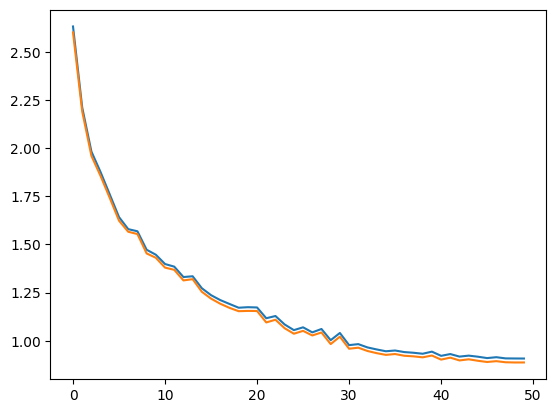

In [33]:
from utils import plot_ray_results
plot_ray_results(results=result, metrics_names = ['rmse_val','rmse_train'])

In [34]:
checkpoint_data = torch.load(os.path.join(result.checkpoint.path,"model.pt"))

model_path = r"./Trained_model/EMS_ANN_v2.pt"
torch.save(checkpoint_data, model_path)

## Test dataset performance

In [39]:
# position unit mm, current unit Ampere
sparsity = 1
Current_position_test =data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :15].reshape(-1,15) 
# B field unit mT
Bfield_test = data[train_file_num:, ::sparsity, ::sparsity, ::sparsity,15:].reshape(-1,3)

num_sample = Current_position_test.shape[0]
print('position shape', Current_position_test.shape)
print('Bfield shape', Bfield_test.shape)

# construct dataset
test_set = eMNS_Dataset(
    x=Current_position_test,
    y=Bfield_test
)
test_set.test_norm_ANN(extremes=extremes, boundary_index=12)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=train_loop_config['batch_size'],
    shuffle=False)


position shape torch.Size([4260060, 15])
Bfield shape torch.Size([4260060, 3])


In [40]:
from utils import predict_check_rmse_ANN, check_rmse_ANN
from Training_loop_v2 import construct_model_ANN 

model_path = r"./Trained_model/EMS_ANN_v2.pt"
model = torch.load(model_path)['model']

prediction, rmse, mse, Rsquare = predict_check_rmse_ANN(test_loader, model, device, extremes[4], extremes[5])
# check_rmse_ANN(test_loader, model, device, extremes[4], extremes[5])

Got rmse 0.9179601669311523


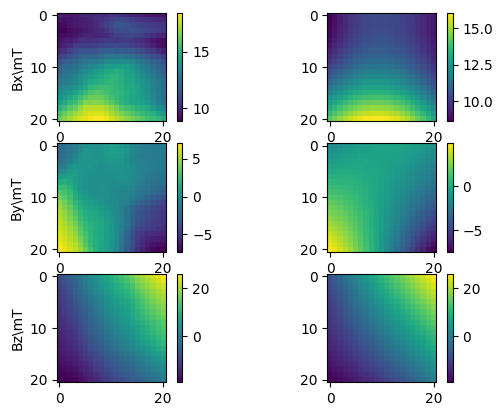

In [42]:
import matplotlib.pyplot as plt
import numpy as np
B_est = prediction.reshape(-1, grid_size, grid_size, grid_size, 3)
Bfield_test = Bfield_test.reshape(-1, grid_size, grid_size, grid_size, 3)

# B_est = prediction.reshape(-1, 6, 6, 6, 3)
# Bfield_test = Bfield_test.reshape(-1, 6, 6, 6, 3)

current_index=3
z_plane_index= 5
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est[current_index,:,:,z_plane_index,i-1])    
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_test[current_index,:,:,z_plane_index,i-1])
    plt.colorbar()
plt.show()